# Assessing the Bird Vox Detect Outputs Against Annotations

In [1]:
from os import listdir
from os.path import isfile, join
import sys
import datetime as dt
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Get all the files in Output folder
Understanding what files are in the output folder

In [2]:
path = config.dataFol+'wsp_bird_sample_bvox_output'

bvox = [f for f in listdir(path) if isfile(join(path, f))]

In [3]:
bvox[:5]

['b827eb0fedda_1559120894.83_confidence.hdf5',
 'b827eb815321_1557565145.06_confidence.hdf5',
 'b827eb0fedda_1556358237.76_checklist.csv',
 'b827eb1685c7_1554629493.05_confidence.hdf5',
 'b827eb0fedda_1549797841.59_confidence.hdf5']

In [4]:
bvox_df = pd.DataFrame(map(lambda sub: sub.split('_'), bvox),
                       columns=['sensor', 'unixtime', 'type'])

bvox_df['file'] = bvox
bvox_df['timestamp'] = pd.to_datetime(bvox_df['unixtime'], unit='s')

bvox_df.head()

,sensor,unixtime,type,file,timestamp
0,b827eb0fedda,1559120894.83,confidence.hdf5,b827eb0fedda_1559120894.83_confidence.hdf5,2019-05-29 09:08:14.829999924
1,b827eb815321,1557565145.06,confidence.hdf5,b827eb815321_1557565145.06_confidence.hdf5,2019-05-11 08:59:05.059999943
2,b827eb0fedda,1556358237.76,checklist.csv,b827eb0fedda_1556358237.76_checklist.csv,2019-04-27 09:43:57.759999990
3,b827eb1685c7,1554629493.05,confidence.hdf5,b827eb1685c7_1554629493.05_confidence.hdf5,2019-04-07 09:31:33.049999952
4,b827eb0fedda,1549797841.59,confidence.hdf5,b827eb0fedda_1549797841.59_confidence.hdf5,2019-02-10 11:24:01.589999914


In [5]:
bvox_df.sensor.unique()

array(['b827eb0fedda', 'b827eb815321', 'b827eb1685c7', 'b827eb8e2420',
       'b827eb86d458', 'b827eb905497'], dtype=object)

### Map SONYC sensor ids to sensor names

In [6]:
sensors = pd.read_json(config.dataFol+"sonyc_test.collection.json")
sensors['sensor'] = sensors['fqdn'].str[10:22]
bvox_df_named = sensors[['title','sensor']].merge(bvox_df, on='sensor')
bvox_dict = dict(list(bvox_df_named.groupby('title')))

In [7]:
bvox_dict['19 Washington Square North'].sort_values(['unixtime']).head(4)

,title,sensor,unixtime,type,file,timestamp
4993,19 Washington Square North,b827eb815321,1549019655.78,confidence.hdf5,b827eb815321_1549019655.78_confidence.hdf5,2019-02-01 11:14:15.779999971
4963,19 Washington Square North,b827eb815321,1549019655.78,checklist.csv,b827eb815321_1549019655.78_checklist.csv,2019-02-01 11:14:15.779999971
4676,19 Washington Square North,b827eb815321,1549019895.81,checklist.csv,b827eb815321_1549019895.81_checklist.csv,2019-02-01 11:18:15.809999943
5142,19 Washington Square North,b827eb815321,1549019895.81,confidence.hdf5,b827eb815321_1549019895.81_confidence.hdf5,2019-02-01 11:18:15.809999943


In [8]:
for key in bvox_dict.keys():
    print(key)
    bvox_dict[key] = dict(list(bvox_dict[key].groupby('type')))

19 Washington Square North
4 Washington Square North
Juan Carlos
Kimmel Center
Shimkin Reading Room
Silver lab


In [9]:
bvox_dict['19 Washington Square North']['checklist.csv'].head()

,title,sensor,unixtime,type,file,timestamp
4159,19 Washington Square North,b827eb815321,1549537257.86,checklist.csv,b827eb815321_1549537257.86_checklist.csv,2019-02-07 11:00:57.859999895
4160,19 Washington Square North,b827eb815321,1554977294.66,checklist.csv,b827eb815321_1554977294.66_checklist.csv,2019-04-11 10:08:14.660000086
4168,19 Washington Square North,b827eb815321,1552301181.38,checklist.csv,b827eb815321_1552301181.38_checklist.csv,2019-03-11 10:46:21.380000114
4171,19 Washington Square North,b827eb815321,1551180646.06,checklist.csv,b827eb815321_1551180646.06_checklist.csv,2019-02-26 11:30:46.059999943
4172,19 Washington Square North,b827eb815321,1549798037.21,checklist.csv,b827eb815321_1549798037.21_checklist.csv,2019-02-10 11:27:17.210000038


### Define Function to get all the csv files into 1 dataframe per sensor

In [10]:
def get_checklist_csv(df, dir_path):
    df_list = []
    for index, row in df.iterrows():
        temp_df = pd.read_csv(dir_path+'/'+row['file'])
        if temp_df.empty:
            # fill in the empty frame if no birds were detected
            temp_df = temp_df.append({'Confidence (%)':None, 
                                      'Species (4-letter code)':'None Detected', 
                                      'Time (hh:mm:ss)':None}, ignore_index=True)
        temp_df['unixtime'] = row['unixtime']
        temp_df['timestamp'] = row['timestamp']
        temp_df['sensor_id'] = row['sensor']
        temp_df['sensor_name'] = row['title']
        df_list.append(temp_df)
    df_fin = pd.concat(df_list)
    return(df_fin)

In [11]:
df_list = []
for key in bvox_dict.keys():
    temp_df = get_checklist_csv(df = bvox_dict[key]['checklist.csv'], dir_path = path)
    df_list.append(temp_df)
all_bvox = pd.concat(df_list)

In [12]:
all_bvox.reset_index(inplace=True)

In [13]:
all_bvox.rename(columns={'Species (4-letter code)':'bvox_species_4_letter_code', 
                        'Confidence (%)': 'confidence_pct'}, 
               inplace=True)

In [14]:
all_bvox.bvox_species_4_letter_code.unique()

array(['SWTH', 'GCTH', 'OVEN', 'None Detected', 'OTHE', 'CAWA', 'WTSP',
       'AMRE', 'SAVS', 'COYE', 'BBWA', 'MOWA', 'BTBW', 'RBGR'],
      dtype=object)

In [15]:
all_bvox.shape

(5796, 8)

### Bring in Andrew's Annotations

In [16]:
ann = pd.read_csv(config.dataFol+'bird_audio_annotations_AF20200610.txt', sep="\t")
ann['file'] = ann['Begin Path'].str[33:-4]
ann[['sensor_id', 'unixtime']] = ann['file'].str.split('_', expand=True)

In [17]:
ann_short = ann[['sensor_id', 'unixtime', 'Species', 'Family', 'Order']].copy()

In [18]:
ann_short.rename(columns = {'Species':'annotated_species', 
                     'Family':'annotated_family', 
                     'Order':'annotated_order'}, inplace=True)

In [19]:
ann_short.sensor_id.unique()

array(['b827eb905497', 'b827eb8e2420', 'b827eb86d458', 'b827eb815321',
       'b827eb1685c7', 'b827eb0fedda'], dtype=object)

In [20]:
ann_short.annotated_species.unique()

array(['WTSP', nan, 'CHSP', 'SWTH', 'SWSP', 'SOSP'], dtype=object)

In [21]:
ann_short.loc[ann_short.annotated_species.isnull()] = 'None Detected'

In [22]:
ann_short.shape

(245, 5)

In [23]:
bvox_ann = all_bvox.merge(ann_short,left_on =['sensor_id', 'unixtime'],
                          right_on =['sensor_id', 'unixtime'], how='inner')
bvox_ann.drop(columns = ['index', 'Time (hh:mm:ss)'], inplace=True)

In [24]:
bvox_ann.to_csv(config.dataFol+'clean_bvox_outputs_annotations.csv')

In [25]:
bvox_ann.shape

(221, 9)

### Assessing the Accuracy, Precision, and Recall using multilabel_confusion_matrix

In [26]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [27]:
bvox_ann.head()

,bvox_species_4_letter_code,confidence_pct,unixtime,timestamp,sensor_id,sensor_name,annotated_species,annotated_family,annotated_order
0,GCTH,56.8934,1556531780.59,2019-04-29 09:56:20.589999914,b827eb815321,19 Washington Square North,WTSP,Sparrow,Passerine
1,SAVS,55.846,1555927610.79,2019-04-22 10:06:50.789999962,b827eb815321,19 Washington Square North,CHSP,Sparrow,Passerine
2,GCTH,53.5423,1555927610.79,2019-04-22 10:06:50.789999962,b827eb815321,19 Washington Square North,CHSP,Sparrow,Passerine
3,SWTH,59.1574,1555927610.79,2019-04-22 10:06:50.789999962,b827eb815321,19 Washington Square North,CHSP,Sparrow,Passerine
4,WTSP,99.99,1555237020.05,2019-04-14 10:17:00.049999952,b827eb815321,19 Washington Square North,SOSP,Sparrow,Passerine


In [28]:
bvox_ann.bvox_species_4_letter_code.unique()

array(['GCTH', 'SAVS', 'SWTH', 'WTSP', 'None Detected', 'OTHE', 'OVEN'],
      dtype=object)

In [29]:
bvox_ann.annotated_species.unique()

array(['WTSP', 'CHSP', 'SOSP', 'SWSP', 'SWTH'], dtype=object)

In [30]:
y_true = bvox_ann.annotated_species
y_pred = bvox_ann.bvox_species_4_letter_code
classes = bvox_ann.annotated_species.unique()

In [31]:
cm = confusion_matrix(y_true, y_pred, labels = classes)
cm

array([[ 9,  0,  0,  0, 34],
       [ 0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [32]:
print(classification_report(y_true, y_pred, labels = classes))

              precision    recall  f1-score   support

        WTSP       0.90      0.04      0.08       209
        CHSP       0.00      0.00      0.00         7
        SOSP       0.00      0.00      0.00         3
        SWSP       0.00      0.00      0.00         1
        SWTH       0.00      0.00      0.00         1

   micro avg       0.20      0.04      0.07       221
   macro avg       0.18      0.01      0.02       221
weighted avg       0.85      0.04      0.08       221



/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
# https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


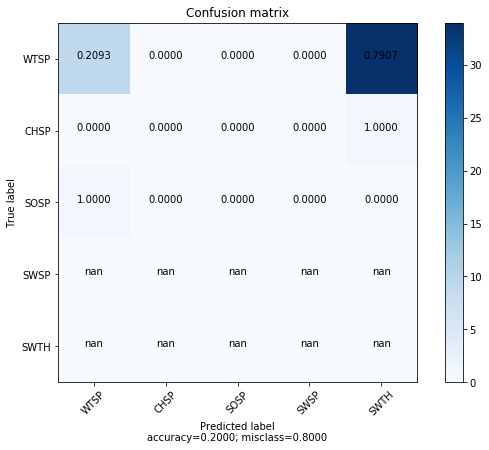

In [34]:
plot_confusion_matrix(cm=cm, 
                     target_names=classes)